In [2]:
import os, cv2, json
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

### 1. Đếm số lượng file

In [4]:
orig_path = 'real-world-inv'
sub_folder_list = os.listdir(orig_path)
sub_folder_list

['.DS_Store', 'formatted_json', 'image', 'labelled_json', 'Previous_label.txt']

In [5]:
image_list = os.listdir(os.path.join(orig_path, sub_folder_list[2]))
print(f'Có {len(image_list)}')

Có 1000


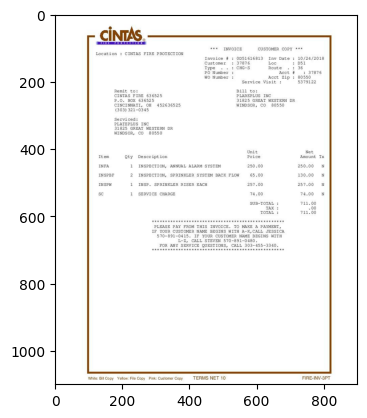

In [6]:
img = cv2.imread(os.path.join(os.path.join(orig_path, sub_folder_list[2]), image_list[0]))
plt.imshow(img)

In [7]:
img.shape

(1100, 900, 3)

### 2. Phân tích ảnh

A. Kiểm tra kích thước

In [8]:
image_folder_path = os.path.join(orig_path, sub_folder_list[2])

def get_common_size(folder_path, image_list):
    size_dict = {}
    for name in tqdm(image_list):
        with Image.open(os.path.join(image_folder_path, name)) as img:
            size = img.size
            if size_dict is not None:
                if size not in size_dict.keys():
                    size_dict[size] = 1
                else:
                    size_dict[size] += 1
            else:
                size_dict[size] = 1
    return size_dict

In [9]:
size_dict = get_common_size(image_folder_path, image_list)

  3%|▎         | 26/1000 [00:00<00:03, 248.87it/s]

100%|██████████| 1000/1000 [00:07<00:00, 141.64it/s]


In [10]:
len(size_dict)

54

Có tất cả 54 loại kích thước trong bộ data mẫu.

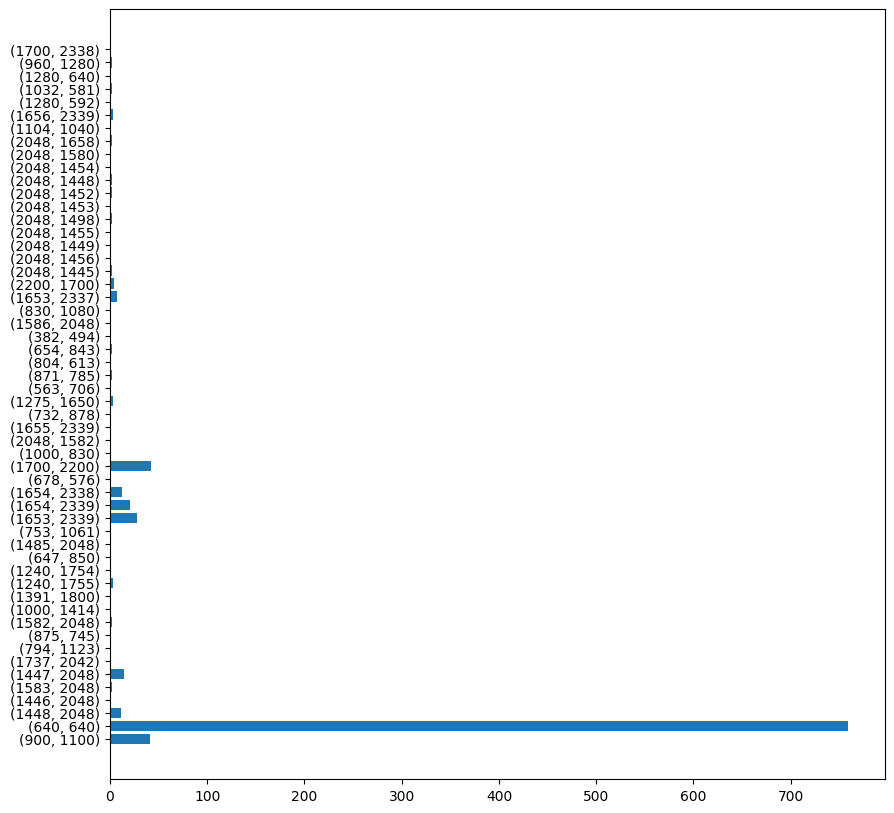

In [11]:
plt.figure(figsize=((10, 10)))
plt.barh(range(len(size_dict)), list(size_dict.values()))
plt.yticks(range(len(size_dict)), list(size_dict.keys()))
plt.show()

Có thể thấy kích thước trung bình của các ảnh là 640x640 với 749 ảnh.  

B. Kiểm tra loại hình ảnh

In [12]:
import numpy as np

digital_img = cv2.imread(os.path.join(image_folder_path, image_list[np.random.randint(10)]))
relife_img = cv2.imread(os.path.join(image_folder_path, 'WhatsApp-Image-2020-08-17-at-13-02-53_jpeg_jpg.rf.5a4fd7366a11320eb9b9eff8266475f0.jpg'))

Text(0.5, 1.0, 'Real-life Image')

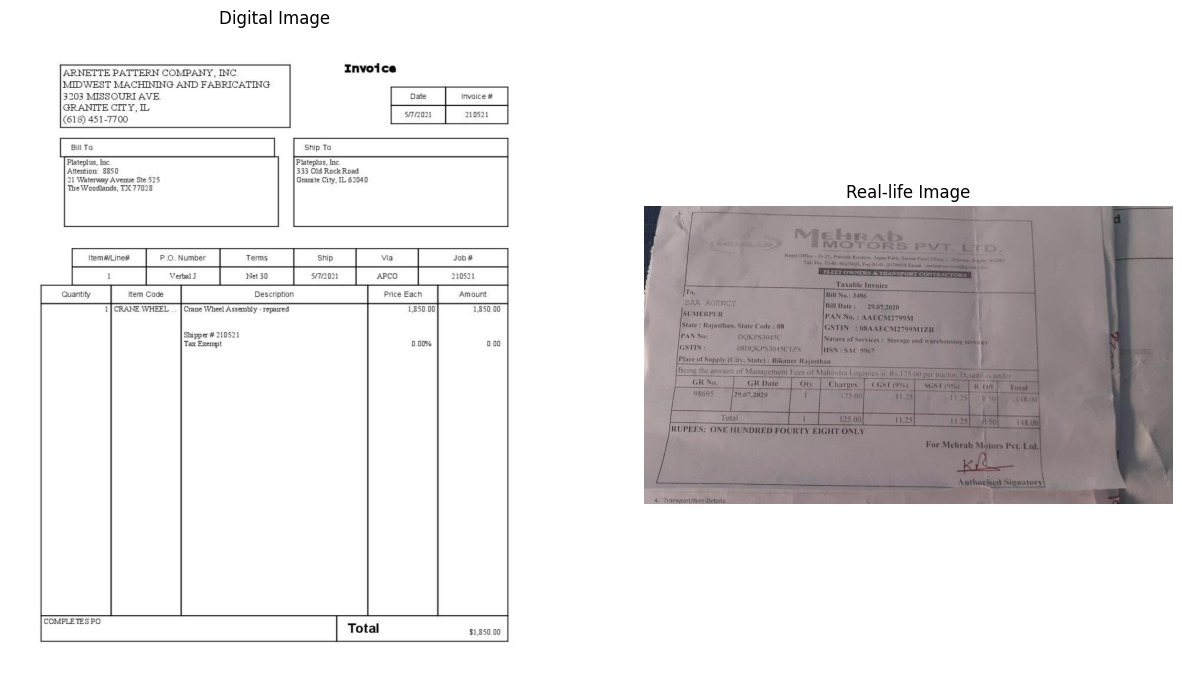

In [13]:
fig = plt.figure(figsize=(15, 13))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(digital_img) 
plt.axis('off') 
plt.title("Digital Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(relife_img) 
plt.axis('off') 
plt.title("Real-life Image")

Ngoài những hình ảnh hóa đơn điện tử, còn có những hình ảnh hóa đơn từ không gian thực.

### 3. Phân tích annotations

Bên trong folder real-world-inv có 2 loại annotations: 1 cho Table extraction, 1 cho KIE. Mình sẽ đi phân tích từng loại một.

#### A. Labelled_json

In [14]:
label_path = os.path.join(orig_path, sub_folder_list[3])
label_file_list = os.listdir(label_path)
len(label_file_list)

992

Chỉ có khoảng 992 file annotations của Table extraction, vì đây là dữ liệu mẫu nên cũng không cần đủ số lượng.

In [15]:
# Đọc mẫu một file
with open(os.path.join(label_path, label_file_list[0]), 'r') as f:
    content = json.load(f)
content

{'doc_type': 'invoice',
 'bounding_regions': [{'page_number': 1,
   'polygon': [{'x': 0.0, 'y': 0.0},
    {'x': 900.0, 'y': 0.0},
    {'x': 900.0, 'y': 1100.0},
    {'x': 0.0, 'y': 1100.0}]}],
 'spans': [{'offset': 0, 'length': 1078}],
 'fields': {'BillingAddress': {'value_type': 'address',
   'value': {'house_number': '31825',
    'po_box': None,
    'road': 'GREAT WESTERN DR',
    'city': 'WINDSOR',
    'state': 'CO',
    'postal_code': '80550',
    'country_region': None,
    'street_address': '31825 GREAT WESTERN DR'},
   'content': '31825 GREAT WESTERN DR\nWINDSOR, CO 80550',
   'bounding_regions': [{'page_number': 1,
     'polygon': [{'x': 537.0, 'y': 249.0},
      {'x': 712.0, 'y': 249.0},
      {'x': 712.0, 'y': 278.0},
      {'x': 537.0, 'y': 278.0}]}],
   'spans': [{'offset': 373, 'length': 40}],
   'confidence': 0.891},
  'BillingAddressRecipient': {'value_type': 'string',
   'value': 'PLAREPLUS INC',
   'content': 'PLAREPLUS INC',
   'bounding_regions': [{'page_number': 1,


In [16]:
content.keys()

dict_keys(['doc_type', 'bounding_regions', 'spans', 'fields', 'confidence'])

Trong file annotation có 5 loại key chính: doc_type - loại văn bản, bounding_regions - các bboxes, spans - chưa rõ, fields - chưa rõ, confidence - điểm tin cậy. Mình sẽ đi sâu vào từng key để hiểu rõ nội dung bên trong nó.

##### Doc_type

In [17]:
doctype_content = content['doc_type']
doctype_content

'invoice'

Loại dữ liệu chính mà ta sẽ tương tác là hóa đơn. 

##### Bounding_regions

In [18]:
bbox_content = content['bounding_regions']
bbox_content

[{'page_number': 1,
  'polygon': [{'x': 0.0, 'y': 0.0},
   {'x': 900.0, 'y': 0.0},
   {'x': 900.0, 'y': 1100.0},
   {'x': 0.0, 'y': 1100.0}]}]

Bên trong key Bounding_regions có chứa tham số 'page_number' - số trang, 'polygon' chứa 4 tọa độ lần lượt là 4 điểm của hình ảnh, tưởng đương với kích thước ảnh là 900x1100 pixels. 

##### Spans

In [19]:
spans_content = content['spans']
spans_content

[{'offset': 0, 'length': 1078}]

Theo cách mình hiểu có thể tham số 'lengh' là độ cao của phần nội dung (có văn bản) trong hình ảnh. 

##### Fields

In [20]:
fields_content = content['fields']
fields_content

{'BillingAddress': {'value_type': 'address',
  'value': {'house_number': '31825',
   'po_box': None,
   'road': 'GREAT WESTERN DR',
   'city': 'WINDSOR',
   'state': 'CO',
   'postal_code': '80550',
   'country_region': None,
   'street_address': '31825 GREAT WESTERN DR'},
  'content': '31825 GREAT WESTERN DR\nWINDSOR, CO 80550',
  'bounding_regions': [{'page_number': 1,
    'polygon': [{'x': 537.0, 'y': 249.0},
     {'x': 712.0, 'y': 249.0},
     {'x': 712.0, 'y': 278.0},
     {'x': 537.0, 'y': 278.0}]}],
  'spans': [{'offset': 373, 'length': 40}],
  'confidence': 0.891},
 'BillingAddressRecipient': {'value_type': 'string',
  'value': 'PLAREPLUS INC',
  'content': 'PLAREPLUS INC',
  'bounding_regions': [{'page_number': 1,
    'polygon': [{'x': 538.0, 'y': 236.0},
     {'x': 640.0, 'y': 236.0},
     {'x': 640.0, 'y': 249.0},
     {'x': 538.0, 'y': 249.0}]}],
  'spans': [{'offset': 359, 'length': 13}],
  'confidence': 0.936},
 'CustomerId': {'value_type': 'string',
  'value': '37876',
 

In [21]:
keys = list(fields_content.keys())
keys

['BillingAddress',
 'BillingAddressRecipient',
 'CustomerId',
 'CustomerName',
 'InvoiceDate',
 'InvoiceId',
 'InvoiceTotal',
 'Items',
 'RemittanceAddress',
 'RemittanceAddressRecipient',
 'ServiceAddress',
 'ServiceAddressRecipient',
 'SubTotal',
 'TotalTax',
 'VendorName']

In [22]:
print(f'Có tất cả {len(keys)} trường trong hóa đơn.')

Có tất cả 15 trường trong hóa đơn.


Key 'Fields' chứa các trường thông tin - hay các entities trong hóa đơn, đây có thể là các entities quan trọng trong task KIE của mình. Bây giờ mình sẽ đi xem thử trong mỗi field sẽ chứa những thông tin gì.

In [23]:
keys[0]

'BillingAddress'

In [24]:
field1 = fields_content[keys[0]]
field1

{'value_type': 'address',
 'value': {'house_number': '31825',
  'po_box': None,
  'road': 'GREAT WESTERN DR',
  'city': 'WINDSOR',
  'state': 'CO',
  'postal_code': '80550',
  'country_region': None,
  'street_address': '31825 GREAT WESTERN DR'},
 'content': '31825 GREAT WESTERN DR\nWINDSOR, CO 80550',
 'bounding_regions': [{'page_number': 1,
   'polygon': [{'x': 537.0, 'y': 249.0},
    {'x': 712.0, 'y': 249.0},
    {'x': 712.0, 'y': 278.0},
    {'x': 537.0, 'y': 278.0}]}],
 'spans': [{'offset': 373, 'length': 40}],
 'confidence': 0.891}

In [25]:
field1.keys()

dict_keys(['value_type', 'value', 'content', 'bounding_regions', 'spans', 'confidence'])

Tương tự như key gốc của file, trong đó có các cặp tương đương nhau: value_type - doc_type, value - fields, bounding_regions, spans, confidence, content là nội dung chính của field này, trong đó các sub_entities được tách ra thành các values. Để đảm bảo sự đồng bộ về format, ta sẽ kiểm tra nốt thêm 2 field nữa.

In [26]:
fields_content[keys[np.random.randint(15)]]

{'value_type': 'address',
 'value': {'house_number': None,
  'po_box': 'P.O. BOX 636525',
  'road': None,
  'city': 'CINCINNATI',
  'state': 'OH',
  'postal_code': '452636525',
  'country_region': None,
  'street_address': 'P.O. BOX 636525'},
 'content': 'P.O. BOX 636525 CINCINNATI, OH 452636525',
 'bounding_regions': [{'page_number': 1,
   'polygon': [{'x': 175.0, 'y': 249.0},
    {'x': 373.0, 'y': 249.0},
    {'x': 373.0, 'y': 278.0},
    {'x': 175.0, 'y': 278.0}]}],
 'spans': [{'offset': 294, 'length': 40}],
 'confidence': 0.893}

Như vậy có thể thấy các field đều đồng bộ về format. Tuy nhiên, theo cảm tính có thể thấy ở thực thể 'items' có vẻ sẽ có gì đặc biệt. Vậy nên mình sẽ cùng đi phân tích dữ liệu ở chỗ này một xíu để hiểu về field "đặc biệt" này.

In [27]:
items = fields_content[keys[7]]
item_keys = list(items.keys())
item_keys

['value_type', 'value', 'content', 'bounding_regions', 'spans', 'confidence']

In [28]:
items

{'value_type': 'list',
 'value': [{'value_type': 'dictionary',
   'value': {'Amount': {'value_type': 'currency',
     'value': {'amount': 250.0, 'symbol': None},
     'content': '250.00',
     'bounding_regions': [{'page_number': 1,
       'polygon': [{'x': 721.0, 'y': 446.0},
        {'x': 767.0, 'y': 446.0},
        {'x': 767.0, 'y': 458.0},
        {'x': 722.0, 'y': 457.0}]}],
     'spans': [{'offset': 571, 'length': 6}],
     'confidence': 0.93},
    'Description': {'value_type': 'string',
     'value': 'INSPECTION, ANNUAL ALARM SYSTEM',
     'content': 'INSPECTION, ANNUAL ALARM SYSTEM',
     'bounding_regions': [{'page_number': 1,
       'polygon': [{'x': 247.0, 'y': 445.0},
        {'x': 490.0, 'y': 445.0},
        {'x': 490.0, 'y': 459.0},
        {'x': 247.0, 'y': 459.0}]}],
     'spans': [{'offset': 532, 'length': 31}],
     'confidence': 0.928},
    'ProductCode': {'value_type': 'string',
     'value': 'INFA',
     'content': 'INFA',
     'bounding_regions': [{'page_number': 

Như vậy có thể thấy thực thể 'items' sẽ chứa những thông tin quan trọng về sản phẩm, hay nói cách khác là những thông tin dạng bảng (tabular information). Và đây là phần nội dung mà tụi mình quan tâm nhất trong phần TE và cả KIE. 

In [34]:
items_values = items['value']
len(items_values)

4

In [36]:
for i in items_values:
    print(i['value'].keys())

dict_keys(['Amount', 'Description', 'ProductCode', 'Quantity', 'Tax', 'UnitPrice'])
dict_keys(['Amount', 'Description', 'ProductCode', 'Quantity', 'Tax', 'UnitPrice'])
dict_keys(['Amount', 'Description', 'ProductCode', 'Quantity', 'Tax', 'UnitPrice'])
dict_keys(['Amount', 'Description', 'ProductCode', 'Quantity', 'Tax', 'UnitPrice'])


Có thể hiểu 4 giá trị bên trong items_values tương đương với 4 sản phẩm bên trong hóa đơn (có thể quan sát từ hình ảnh), với mỗi sub_value bên trong mỗi value sẽ tương đương với các thuộc tính (tổng giá, mô tả sản phẩm, mã sản phẩm, số lượng, thuế, giá/món).

##### Confidence

In [29]:
content['confidence']

1.0

Có thể hiểu đây là điểm tin cậy về độ chính xác của dữ liệu.

##### Format 
Sau khi đi sâu vào từng key bên trong annotation file, mình có thể rút kết format chung của label như sau:
{}

##### Visualize


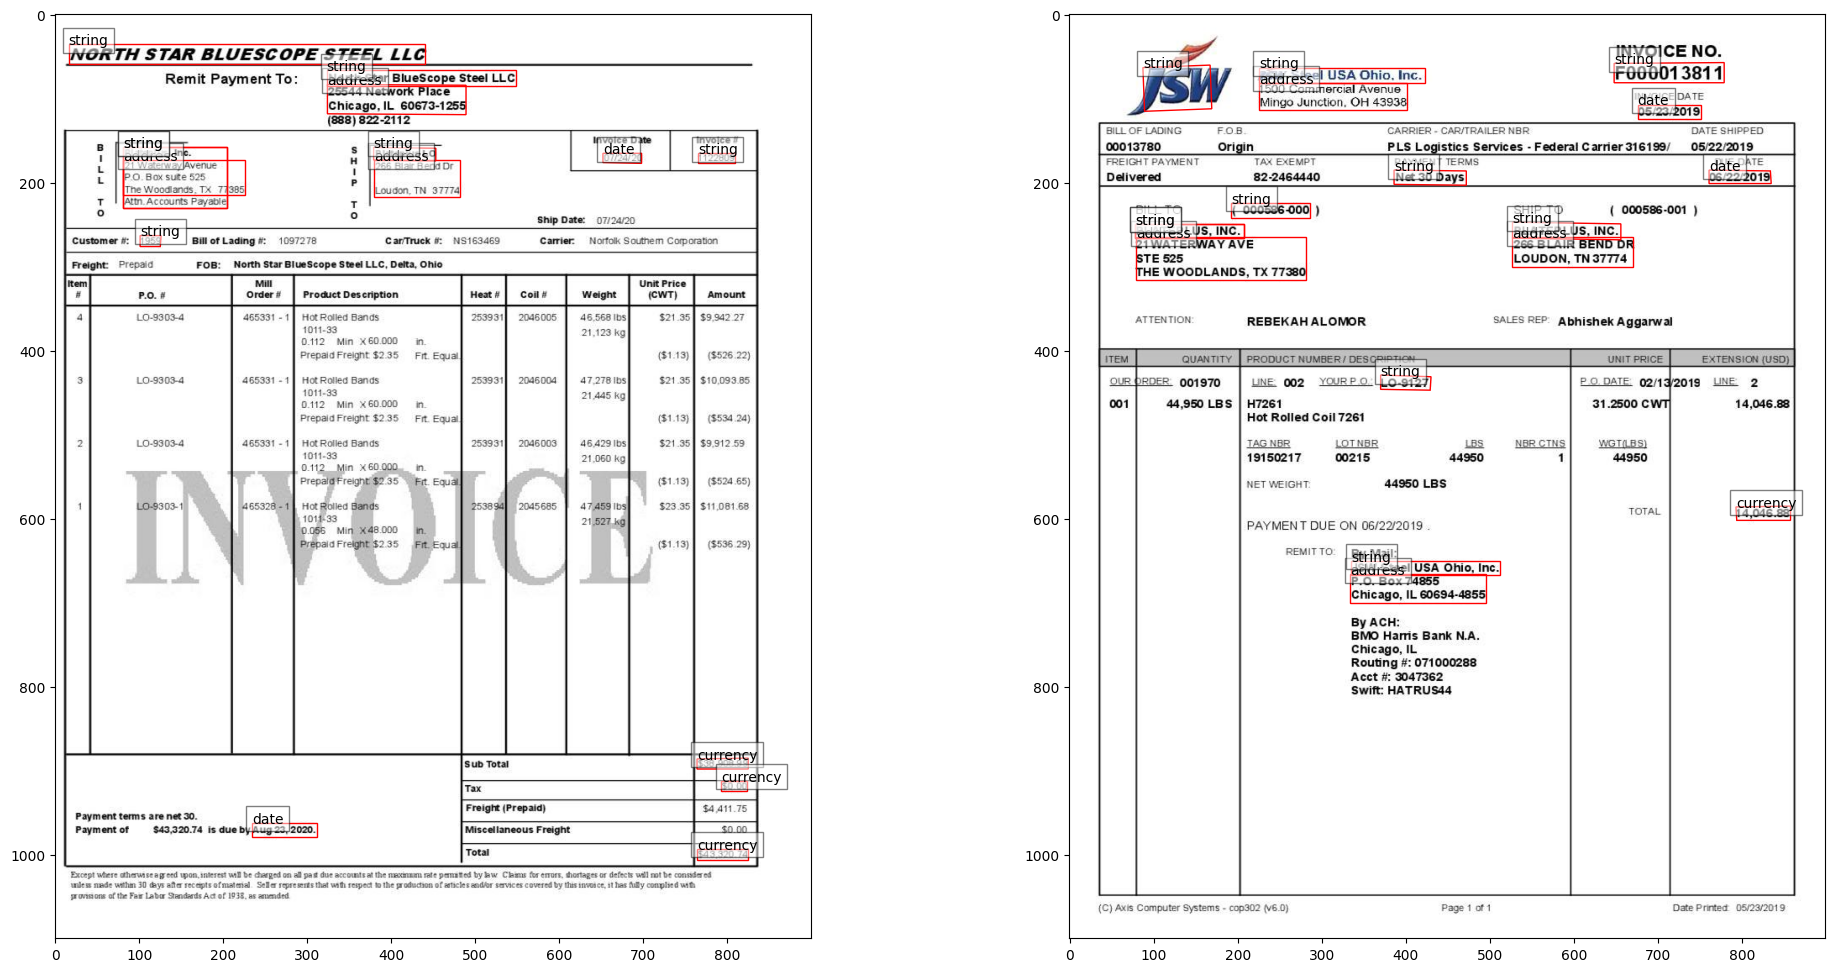

In [3]:
import matplotlib.patches as patches

annotate_dir = r"D:\Study\OJT\addtional_invoice\addtional_invoice\real-world-inv\labelled_json"
img_dir = r"D:\Study\OJT\addtional_invoice\addtional_invoice\real-world-inv\image"


filenames = ['0000NSBS-1122809-png-1_png_jpg.rf.27099ac9a80eccc8a2ba710e1284ad21.json', 
             '0000JSW-13811-png-1_png_jpg.rf.08838a0cc743513f31ce31ecd4f0c0a5.json']  


fig, axs = plt.subplots(1, len(filenames), figsize=(12 * len(filenames), 12))

for ax, filename in zip(axs, filenames):
    
    with open(os.path.join(annotate_dir, filename), 'r') as f:
        data = json.load(f)

    
    img_filename = os.path.splitext(filename)[0] + '.jpg'  
    im = Image.open(os.path.join(img_dir, img_filename))

    ax.grid(False)

    
    ax.imshow(im)

    
    for field in data['fields'].values():
        for region in field['bounding_regions']:
            polygon = region['polygon']
            xs = [point['x'] for point in polygon]
            ys = [point['y'] for point in polygon]
            rect = patches.Polygon(xy=list(zip(xs, ys)), linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xs[0], ys[0], field['value_type'], bbox=dict(facecolor='white', alpha=0.5))

plt.show()


#### B. Formatted_json

In [30]:
format_path = os.path.join(orig_path, sub_folder_list[1])
format_file_list = os.listdir(label_path)
len(format_file_list)

992

Chỉ có khoảng 983 file label cho phần format này. Tương tự phần labelled_json, mình cũng sẽ lấy mẫu một vài file ra để phân tích nội dung bên trong đó.

In [31]:
with open(os.path.join(format_path, format_file_list[0]), 'r') as file:
    format_content = json.load(file)

format_content

[{'key': 'BillingAddress',
  'value': '31825 GREAT WESTERN DR\nWINDSOR, CO 80550',
  'bbox': [0.5966666666666667,
   0.22636363636363635,
   0.7911111111111111,
   0.25272727272727274]},
 {'key': 'BillingAddressRecipient',
  'value': 'PLAREPLUS INC',
  'bbox': [0.5977777777777777,
   0.21454545454545454,
   0.7111111111111111,
   0.22636363636363635]},
 {'key': 'CustomerId',
  'value': '37876',
  'bbox': [0.6, 0.12636363636363637, 0.6433333333333333, 0.13818181818181818]},
 {'key': 'CustomerName',
  'value': 'PLAREPLUS INC',
  'bbox': [0.5977777777777777,
   0.21454545454545454,
   0.7111111111111111,
   0.22636363636363635]},
 {'key': 'InvoiceDate',
  'value': '10/24/2018',
  'bbox': [0.8011111111111111,
   0.11363636363636363,
   0.8877777777777778,
   0.12454545454545454]},
 {'key': 'InvoiceId',
  'value': '0051616813',
  'bbox': [0.5988888888888889,
   0.11363636363636363,
   0.6866666666666666,
   0.12545454545454546]},
 {'key': 'InvoiceTotal',
  'value': '711.00',
  'bbox': [0.81

In [32]:
print(f'Có {len(format_content)} giá trị bên trong một file format.')

Có 22 giá trị bên trong một file format.


Visualize 

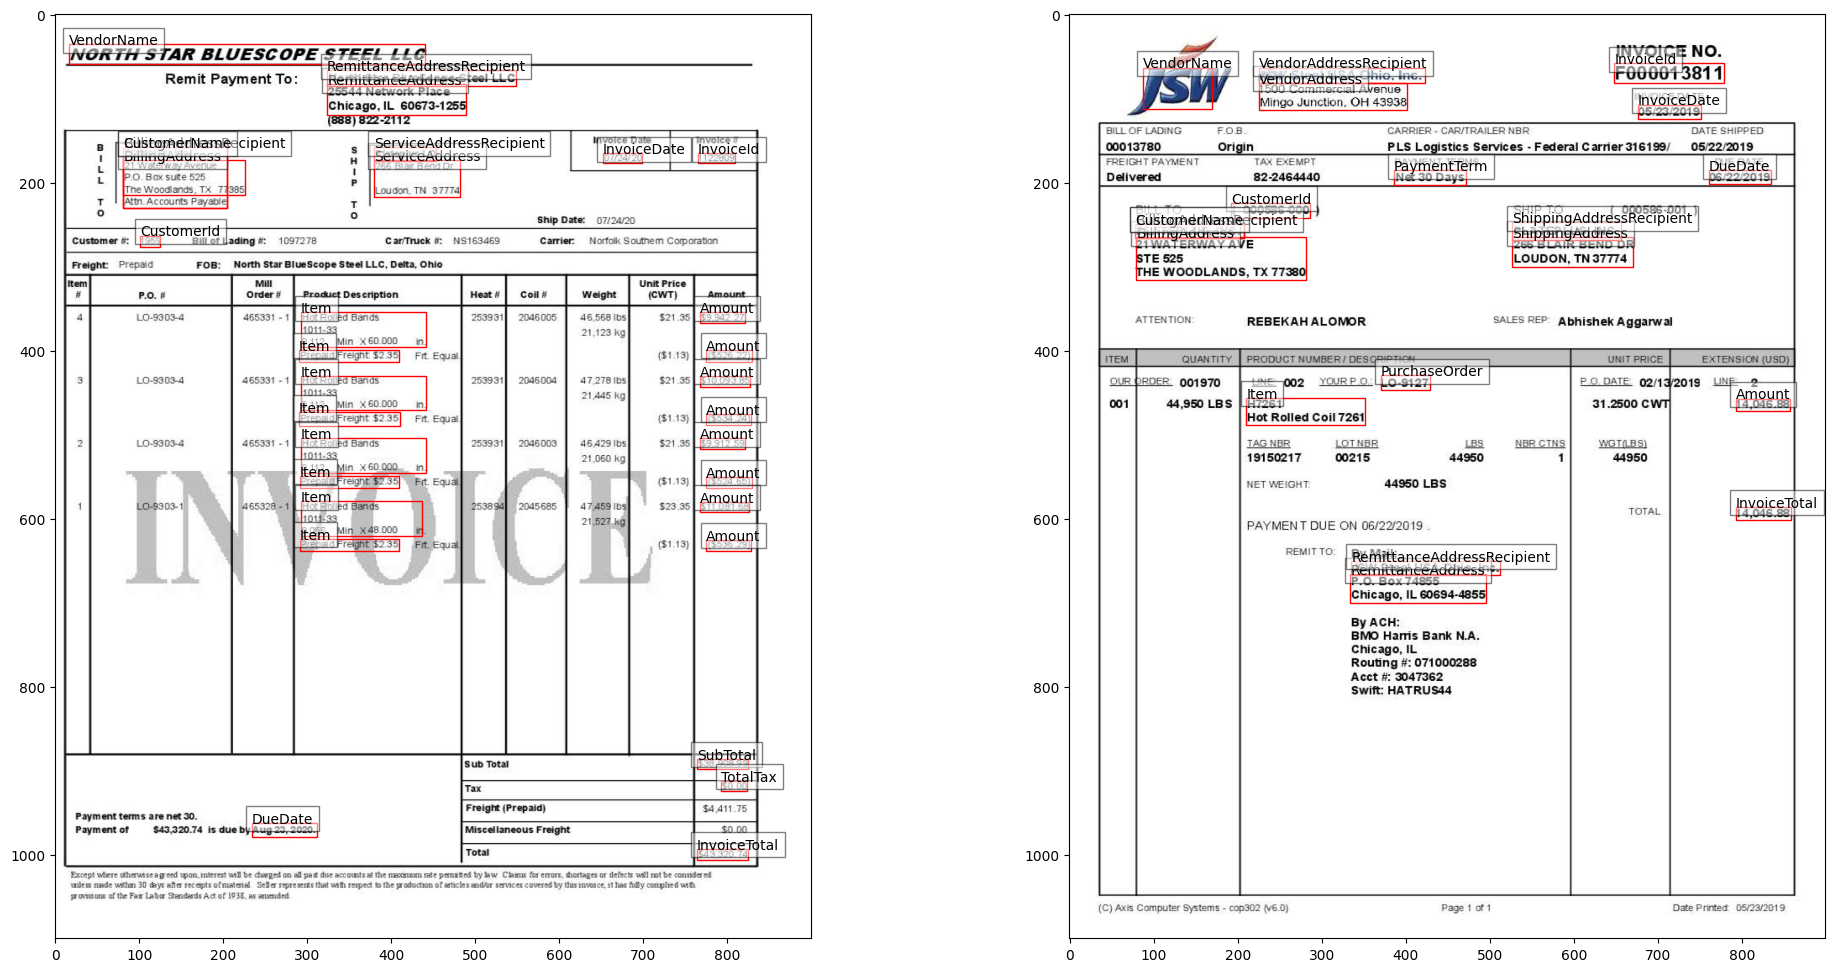

In [4]:

annotate_dir = r"D:\Study\OJT\addtional_invoice\addtional_invoice\real-world-inv\formatted_json"
img_dir = r"D:\Study\OJT\addtional_invoice\addtional_invoice\real-world-inv\image"


filenames = ['0000NSBS-1122809-png-1_png_jpg.rf.27099ac9a80eccc8a2ba710e1284ad21.json', 
             '0000JSW-13811-png-1_png_jpg.rf.08838a0cc743513f31ce31ecd4f0c0a5.json']  


fig, axs = plt.subplots(1, len(filenames), figsize=(12 * len(filenames), 12))

for ax, filename in zip(axs, filenames):
    
    with open(os.path.join(annotate_dir, filename), 'r') as f:
        data = json.load(f)

    img_filename = os.path.splitext(filename)[0] + '.jpg'  
    im = Image.open(os.path.join(img_dir, img_filename))
    ax.grid(False)
    ax.imshow(im)
    
    for annotation in data:       
        x = annotation['bbox'][0] * im.width
        y = annotation['bbox'][1] * im.height
        width = (annotation['bbox'][2] - annotation['bbox'][0]) * im.width
        height = (annotation['bbox'][3] - annotation['bbox'][1]) * im.height
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, annotation['key'], bbox=dict(facecolor='white', alpha=0.5))

plt.show()
